# import

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
from collections import Counter
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier


from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Dataset

In [ ]:
# https://www.kaggle.com/datasets/lampubhutia/loandefault-ltfs-avml-finhack?select=train_LTFS.csv

Описание признаков:
* UniqueID Identifier for customers
* loan_default Payment default in the first EMI on due date
* disbursed_amount Amount of Loan disbursed
* asset_cost Cost of the Asset
* ltv Loan to Value of the asset
* branch_id Branch where the loan was disbursed
* supplier_id Vehicle Dealer where the loan was disbursed
* manufacturer_id Vehicle manufacturer(Hero, Honda, TVS etc.)
* Current_pincode Current pincode of the customer
* Date.of.Birth Date of birth of the customer
* Employment.Type Employment Type of the customer (Salaried/Self Employed)
* DisbursalDate Date of disbursement
* State_ID State of disbursement
* Employee_code_ID Employee of the organization who logged the disbursement
* MobileNo_Avl_Flag if Mobile no. was shared by the customer then flagged as 1
* Aadhar_flag if aadhar was shared by the customer then flagged as 1
* PAN_flag if pan was shared by the customer then flagged as 1
* VoterID_flag if voter was shared by the customer then flagged as 1
* Driving_flag if DL was shared by the customer then flagged as 1
* Passport_flag if passport was shared by the customer then flagged as 1
* PERFORM_CNS.SCORE Bureau Score
* PERFORM_CNS.SCORE.DESCRIPTION Bureau score description
* PRI.NO.OF.ACCTS count of total loans taken by the customer at the time of disbursement Primary accounts are those which the customer has taken for his personal use
* PRI.ACTIVE.ACCTS count of active loans taken by the customer at the time of disbursement
* PRI.OVERDUE.ACCTS count of default accounts at the time of disbursement
* PRI.CURRENT.BALANCE total Principal outstanding amount of the active loans at the time of disbursement
* PRI.SANCTIONED.AMOUNT total amount that was sanctioned for all the loans at the time of disbursement
* PRI.DISBURSED.AMOUNT total amount that was disbursed for all the loans at the time of disbursement
* SEC.NO.OF.ACCTS count of total loans taken by the customer at the time of disbursement Secondary accounts are those which the customer act as a co-applicant or gaurantor
* SEC.ACTIVE.ACCTS count of active loans taken by the customer at the time of disbursement
* SEC.OVERDUE.ACCTS count of default accounts at the time of disbursement
* SEC.CURRENT.BALANCE total Principal outstanding amount of the active loans at the time of disbursement
* SEC.SANCTIONED.AMOUNT total amount that was sanctioned for all the loans at the time of disbursement
* SEC.DISBURSED.AMOUNT total amount that was disbursed for all the loans at the time of disbursement
* PRIMARY.INSTAL.AMT EMI Amount of the primary loan
* SEC.INSTAL.AMT EMI Amount of the secondary loan
* NEW.ACCTS.IN.LAST.SIX.MONTHS New loans taken by the customer in last 6 months before the disbursment
* DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS Loans defaulted in the last 6 months
* AVERAGE.ACCT.AGE Average loan tenure
* CREDIT.HISTORY.LENGTH Time since first loan
* NO.OF_INQUIRIES Enquries done by the customer for loans

In [43]:
# считываем датасет и приводим даты в формат дат
# Кроме того, из признака "День выплаты" вытаскиваем месяц, день, день недели и год выплаты

df = pd.read_csv('train_LTFS.csv')

df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], errors='coerce')
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], errors='coerce')

df['Day_Disbursal'] = df['DisbursalDate'].dt.day
df['DayOfWeek_Disbursal'] = df['DisbursalDate'].dt.dayofweek
df['Month_Disbursal'] = df['DisbursalDate'].dt.month
df['Year_Disbursal'] = df['DisbursalDate'].dt.year

print('original df shape', df.shape)

original df shape (233154, 45)


In [4]:
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Day_Disbursal,DayOfWeek_Disbursal,Month_Disbursal,Year_Disbursal
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,...,0,0,0yrs 0mon,0yrs 0mon,0,0,8,3,3,2018
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,...,0,1,1yrs 11mon,1yrs 11mon,0,1,26,2,9,2018
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,...,0,0,0yrs 0mon,0yrs 0mon,0,0,8,0,1,2018
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,...,0,0,0yrs 8mon,1yrs 3mon,1,1,26,4,10,2018
4,539055,52378,60300,88.39,67,22807,45,1495,1977-09-12,Self employed,...,0,0,0yrs 0mon,0yrs 0mon,1,1,26,2,9,2018


In [4]:
df.isna().sum() # пустые значения только в поле Employment.Type

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [5]:
df.nunique()

UniqueID                               233154
disbursed_amount                        24565
asset_cost                              46252
ltv                                      6579
branch_id                                  82
supplier_id                              2953
manufacturer_id                            11
Current_pincode_ID                       6698
Date.of.Birth                           15433
Employment.Type                             2
DisbursalDate                              84
State_ID                                   22
Employee_code_ID                         3270
MobileNo_Avl_Flag                           1
Aadhar_flag                                 2
PAN_flag                                    2
VoterID_flag                                2
Driving_flag                                2
Passport_flag                               2
PERFORM_CNS.SCORE                         573
PERFORM_CNS.SCORE.DESCRIPTION              20
PRI.NO.OF.ACCTS                   

In [3]:
# в описании датасета явно указано, что в признаке Employment.Type всего 2 уникальных значения:
# Salaried и Self employed, поэтому можно будет запонить NaN-значения Salaried

# Также, можно запонить NaN "unemployed"

Counter(df['Employment.Type'])

Counter({'Salaried': 97858, 'Self employed': 127635, nan: 7661})

In [7]:
df.iloc[:, 0:18].describe() # описание первых 18 колонок

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,1.0,0.84032,0.075577,0.144943,0.023242
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,0.0,0.36631,0.264320,0.352044,0.150672
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.00000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,1.0,1.00000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,1.0,1.00000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,1.0,1.00000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,1.0,1.00000,1.000000,1.000000,1.000000


In [8]:
df.iloc[:, 18:].describe() # описание остальных колонок

,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,...,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,Day_Disbursal,DayOfWeek_Disbursal,Month_Disbursal,Year_Disbursal
count,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,...,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.0
mean,0.002127,289.462994,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,0.059081,0.027703,...,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071,20.134285,2.833239,8.796109,2018.0
std,0.046074,338.374779,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,0.626795,0.316057,...,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252,7.612427,1.924213,1.778900,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,2018.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,14.000000,1.000000,8.000000,2018.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000,9.000000,2018.0
75%,0.000000,678.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,0.000000,0.000000,...,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,27.000000,4.000000,10.000000,2018.0
max,1.000000,890.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,...,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000,31.000000,6.000000,12.000000,2018.0


In [45]:
# удалим пустые значения и дубликаты для анализа
df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)


# признаки "Средний срок действия кредита" и "время кридитной истории" записына в датасет как str в формате "2yrs 11mon".
# переведем такую запись в месяцы (2*12 + 11)

df['AVERAGE.ACCT.AGE'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['AVERAGE.ACCT.AGE']]
df['CREDIT.HISTORY.LENGTH'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['CREDIT.HISTORY.LENGTH']]

print('shape after drop', df.shape)

shape after drop (225493, 45)


# EDA

In [5]:
df.select_dtypes('int64').iloc[:, 0:18].head(2) # числовые колонки (первые 18)

,UniqueID,disbursed_amount,asset_cost,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS
0,420825,50578,58400,67,22807,45,1441,6,1998,1,1,0,0,0,0,0,0,0
1,537409,47145,65550,67,22807,45,1502,6,1998,1,1,0,0,0,0,598,1,1


In [6]:
df.select_dtypes('int64').iloc[:, 18:].head(2) # числовые колонки оставшиеся

,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,Day_Disbursal,DayOfWeek_Disbursal,Month_Disbursal,Year_Disbursal
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,3,2018
1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,0,1,26,2,9,2018


In [7]:
df.select_dtypes('object').head(2) # колонки с категориальными признаками

,Employment.Type,PERFORM_CNS.SCORE.DESCRIPTION,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH
0,Salaried,No Bureau History Available,0yrs 0mon,0yrs 0mon
1,Self employed,I-Medium Risk,1yrs 11mon,1yrs 11mon


In [8]:
df.select_dtypes('datetime').head(2) # колонки с датами

,Date.of.Birth,DisbursalDate
0,1984-01-01,2018-03-08
1,1985-07-31,2018-09-26


In [12]:
print('columns count of int columns - ', df.select_dtypes('int').shape[1])
print('columns count of object columns - ', df.select_dtypes('object').shape[1])
print('columns count of datetime columns - ', df.select_dtypes('datetime').shape[1])

columns count of int columns -  38
columns count of object columns -  4
columns count of datetime columns -  2


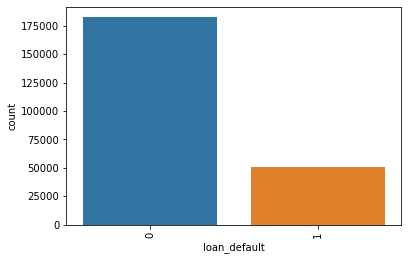

0    182543
1     50611
Name: loan_default, dtype: int64

In [19]:
# распределение таргета. Видно, что классы дисбалансны

sns.countplot(x='loan_default', data=df)
plt.xticks(rotation=90)
plt.show()

df['loan_default'].value_counts()

(array([0, 1]), [Text(0, 0, 'Salaried'), Text(1, 0, 'Self employed')])

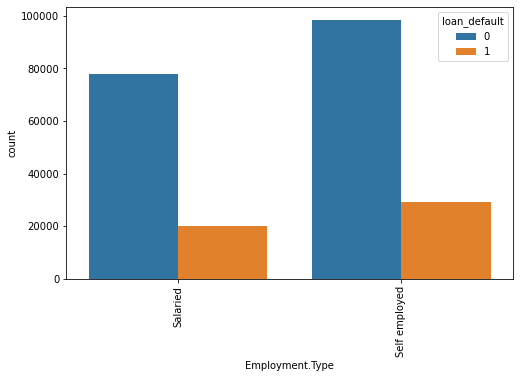

In [20]:
plt.rcParams['figure.figsize'] = (8, 5)

plt.subplot(1, 1, 1)
sns.countplot(x='Employment.Type', data=df, hue='loan_default')
plt.xticks(rotation=90)

<AxesSubplot:xlabel='Date.of.Birth', ylabel='Count'>

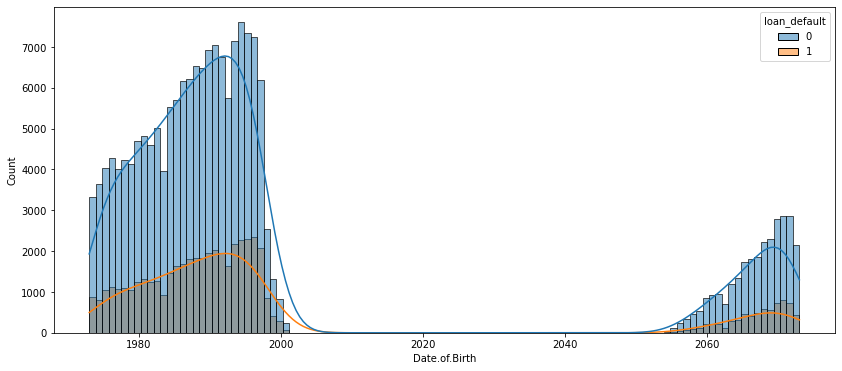

In [21]:
# распределение года рождения и таргета
# видно, что в данных есть ошибки - они будут исправлены при построении моделей 

plt.figure(figsize=(14, 6))
sns.histplot(x='Date.of.Birth', bins=110, hue='loan_default', data=df,
             color = (np.random.random(), np.random.random(), np.random.random()), kde=True, common_norm=True)

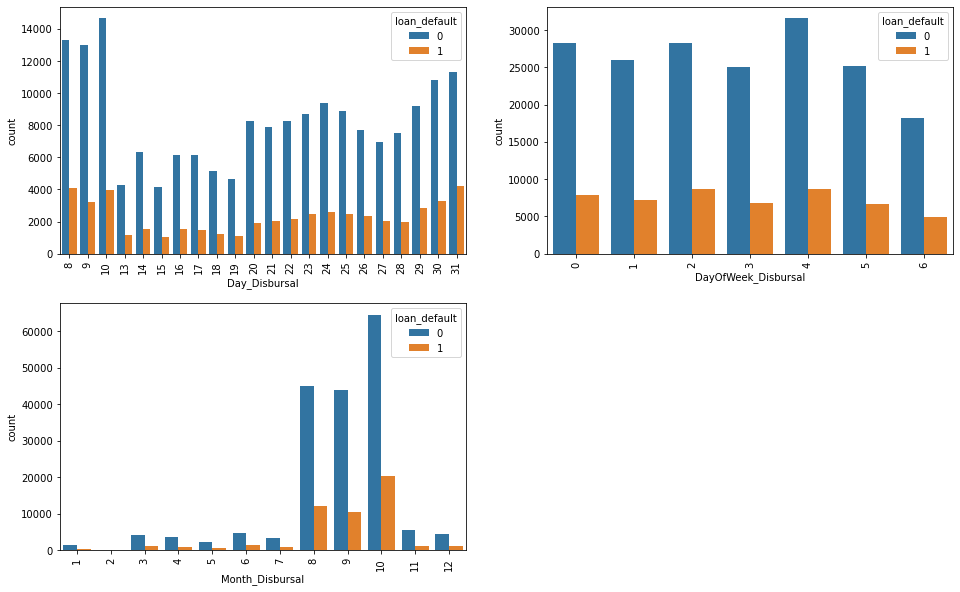

In [36]:
plt.rcParams['figure.figsize'] = (16, 10)

plt.subplot(2, 2, 1)
sns.countplot(x='Day_Disbursal', data=df, hue='loan_default')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.countplot(x='DayOfWeek_Disbursal', data=df, hue='loan_default')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.countplot(x='Month_Disbursal', data=df, hue='loan_default')
plt.xticks(rotation=90)

plt.show()

In [ ]:
# из данных видно, что меньше всего выплат по кредиту происходит между 13 и 19 числами месяца, 
# ближе к концу месяца начинают расти

# по рабочим дням недели выплаты примерно равны, в выходные снижаются. 
# (если считать, что первый день недели - понедельник)

# по месяцам выплат лидируют август, сентябрь, октябрь

In [35]:
df['Year_Disbursal'].value_counts() # все выплаты были сделаны в 2018, поэтому не будем учитывать этот фактор

2018    233154
Name: Year_Disbursal, dtype: int64

<AxesSubplot:>

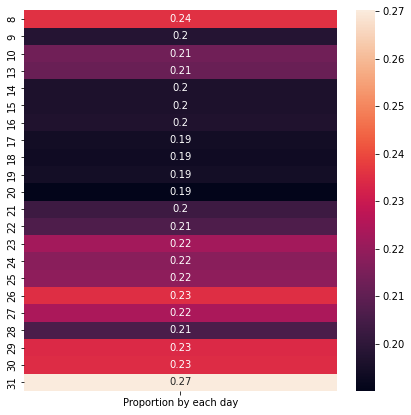

In [22]:
# сравним количество выплат в разные дни месяца

unique = np.unique(df['Day_Disbursal'])
props = []

for uniq in unique:
    uniq_val_count = df['loan_default'][df['Day_Disbursal']==uniq].value_counts()
    props.append(uniq_val_count[1] / (uniq_val_count[1] + uniq_val_count[0]))

plt.figure(figsize=(7, 7))

sns.heatmap(pd.DataFrame(props, 
                         columns=['Proportion by each day'], 
                         index=pd.Index(unique)), annot=True)

# меньше всего дефолтов по выплатам происходит с 9 по 22 число, увеличиваясь к концу месяца

<AxesSubplot:>

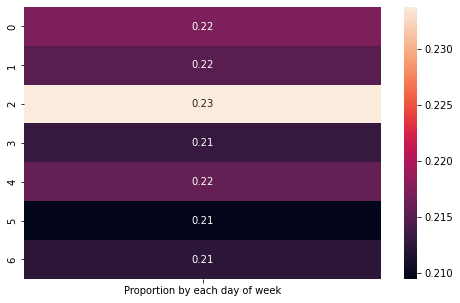

In [45]:
unique = np.unique(df['DayOfWeek_Disbursal'])
props = []

for uniq in unique:
    props.append(df['loan_default'][df['DayOfWeek_Disbursal']==uniq].value_counts()[1]/ \
                        (df['loan_default'][df['DayOfWeek_Disbursal']==uniq].value_counts()[1]+ \
                         df['loan_default'][df['DayOfWeek_Disbursal']==uniq].value_counts()[0]))
    
sns.heatmap(pd.DataFrame(props, 
                         columns=['Proportion by each day of week'], 
                         index=pd.Index(unique)), annot=True)

# количество дефолтов равномерно, не зависит от дня недели

<AxesSubplot:>

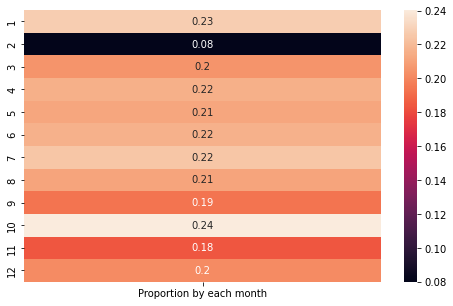

In [46]:
unique = np.unique(df['Month_Disbursal'])
props = []

for uniq in unique:
    props.append(df['loan_default'][df['Month_Disbursal']==uniq].value_counts()[1]/ \
                        (df['loan_default'][df['Month_Disbursal']==uniq].value_counts()[1]+ \
                         df['loan_default'][df['Month_Disbursal']==uniq].value_counts()[0]))
    
sns.heatmap(pd.DataFrame(props, 
                         columns=['Proportion by each month'], 
                         index=pd.Index(unique)), annot=True)

# дефолты растут начиная с февраля, пик приходится на октябрь
# минимальный % деволтов приходится на февраль и декабрь

<AxesSubplot:xlabel='Bureau', ylabel='Count'>

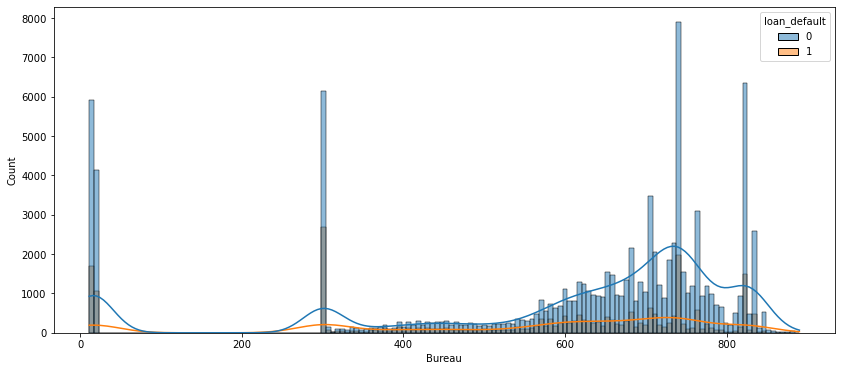

In [26]:
# рейтинг кредитоспособности без пустых значений (0, когда нет данных)
plt.figure(figsize=(14, 6))
temp = df.rename(columns={'PERFORM_CNS.SCORE':'Bureau'}).query('Bureau >= 1')

sns.histplot(x='Bureau', bins=150, hue='loan_default', data=temp,
             kde=True, common_norm=True, log_scale=False)

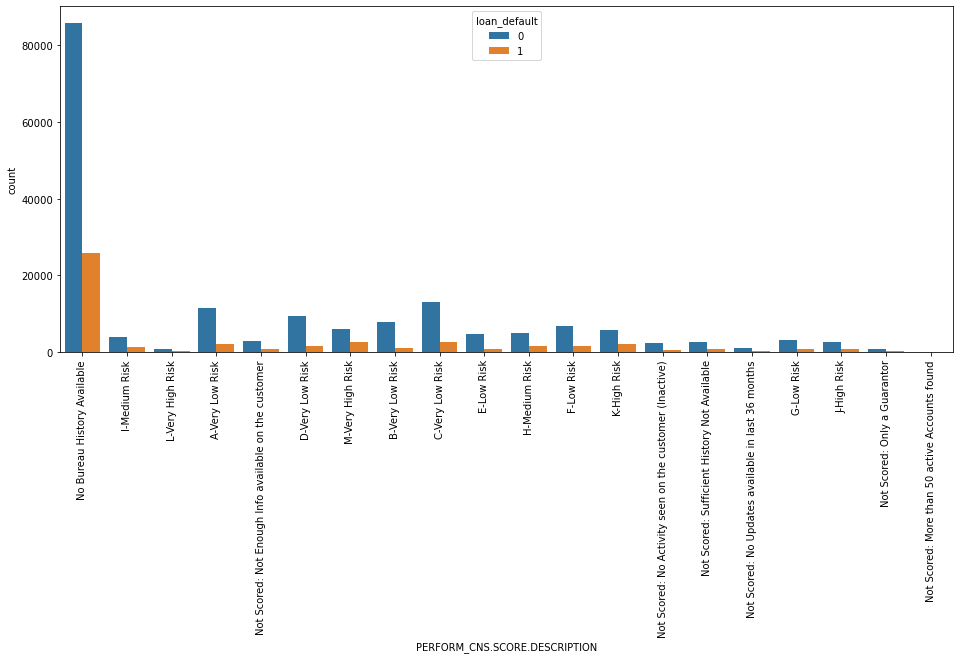

In [16]:
# исключая пустые значения, видно, что клиентов с рейтингом A, D, C больше всего
plt.rcParams['figure.figsize'] = (16, 14)

plt.subplot(2, 1, 1)
sns.countplot(x='PERFORM_CNS.SCORE.DESCRIPTION', data=df, hue='loan_default', )
plt.xticks(rotation=90)

plt.show()

In [52]:
# таблица показывающая статистические данные по Ретингу кредитоспособности
# рейтинг Bureau - от 300 до 900 пунктов

# обычно, больше всего дефолтов у людей с рейтингом M (чуть больше 30%), при это показатель рейтинга 300 (минимальный)

# Также, выделяется рейтинг В, который показывает 13% дефолтов. У более лучшего рейтинга А процент дефолтов выше (?)
# Такая же ситуация с рейтингом С - 17,22% дефолтов при более высоком показателе Bureau



Bureau_statistic = pd.DataFrame()
Bureau_statistic['COUNT'] = df.groupby('PERFORM_CNS.SCORE.DESCRIPTION')['PERFORM_CNS.SCORE'].count()
Bureau_statistic['MEAN'] = df.groupby('PERFORM_CNS.SCORE.DESCRIPTION')['PERFORM_CNS.SCORE'].mean()
Bureau_statistic['MEDIAN'] = df.groupby('PERFORM_CNS.SCORE.DESCRIPTION')['PERFORM_CNS.SCORE'].median()
Bureau_statistic['DEFAULT 0'] = df.query('loan_default==0').groupby('PERFORM_CNS.SCORE.DESCRIPTION')['loan_default'].count()
Bureau_statistic['DEFAULT 1'] = df.query('loan_default==1').groupby('PERFORM_CNS.SCORE.DESCRIPTION')['loan_default'].count()
Bureau_statistic['PROPORTION'] = Bureau_statistic['DEFAULT 1']/(Bureau_statistic['DEFAULT 0']+Bureau_statistic['DEFAULT 1'])


Bureau_statistic.sort_values(by='PROPORTION', ascending=False) \
.style.background_gradient(cmap=sns.light_palette('darkblue', as_cmap=True))

,COUNT,MEAN,MEDIAN,DEFAULT 0,DEFAULT 1,PROPORTION
PERFORM_CNS.SCORE.DESCRIPTION,,,,,,
M-Very High Risk,8632,300.000000,300.000000,6009,2623.000000,0.303869
L-Very High Risk,1122,326.568627,327.000000,806,316.000000,0.281640
K-High Risk,8107,440.635130,441.000000,5853,2254.000000,0.278031
I-Medium Risk,5440,586.817647,587.000000,3957,1483.000000,0.272610
Not Scored: Sufficient History Not Available,3671,15.000000,15.000000,2727,944.000000,0.257151
J-High Risk,3667,549.911099,552.000000,2739,928.000000,0.253068
H-Medium Risk,6695,617.026139,616.000000,5082,1613.000000,0.240926
No Bureau History Available,111773,0.000000,0.000000,85824,25949.000000,0.232158
Not Scored: Only a Guarantor,957,14.000000,14.000000,751,206.000000,0.215256


<AxesSubplot:xlabel='AVERAGE_ACCT_AGE', ylabel='Count'>

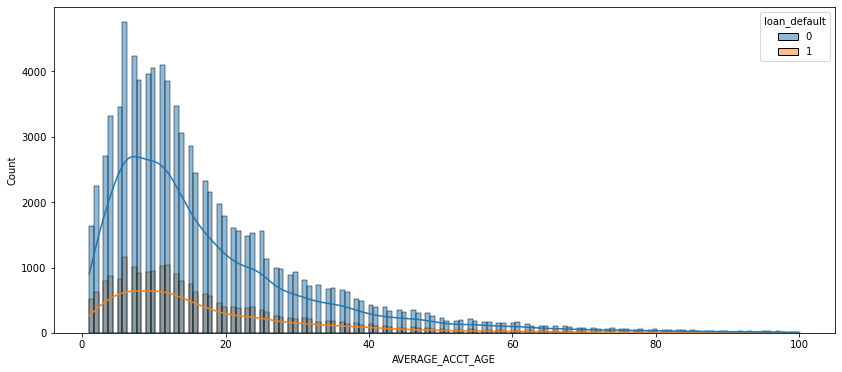

In [146]:
# большинство кредитов берется до 3 лет

plt.figure(figsize=(14, 6))
temp2 = df.rename(columns={'AVERAGE.ACCT.AGE':'AVERAGE_ACCT_AGE'})\
          .query('AVERAGE_ACCT_AGE <= 100 and AVERAGE_ACCT_AGE >=1')

sns.histplot(x='AVERAGE_ACCT_AGE', bins=150, hue='loan_default', data=temp2,
             kde=True, common_norm=True, log_scale=False)

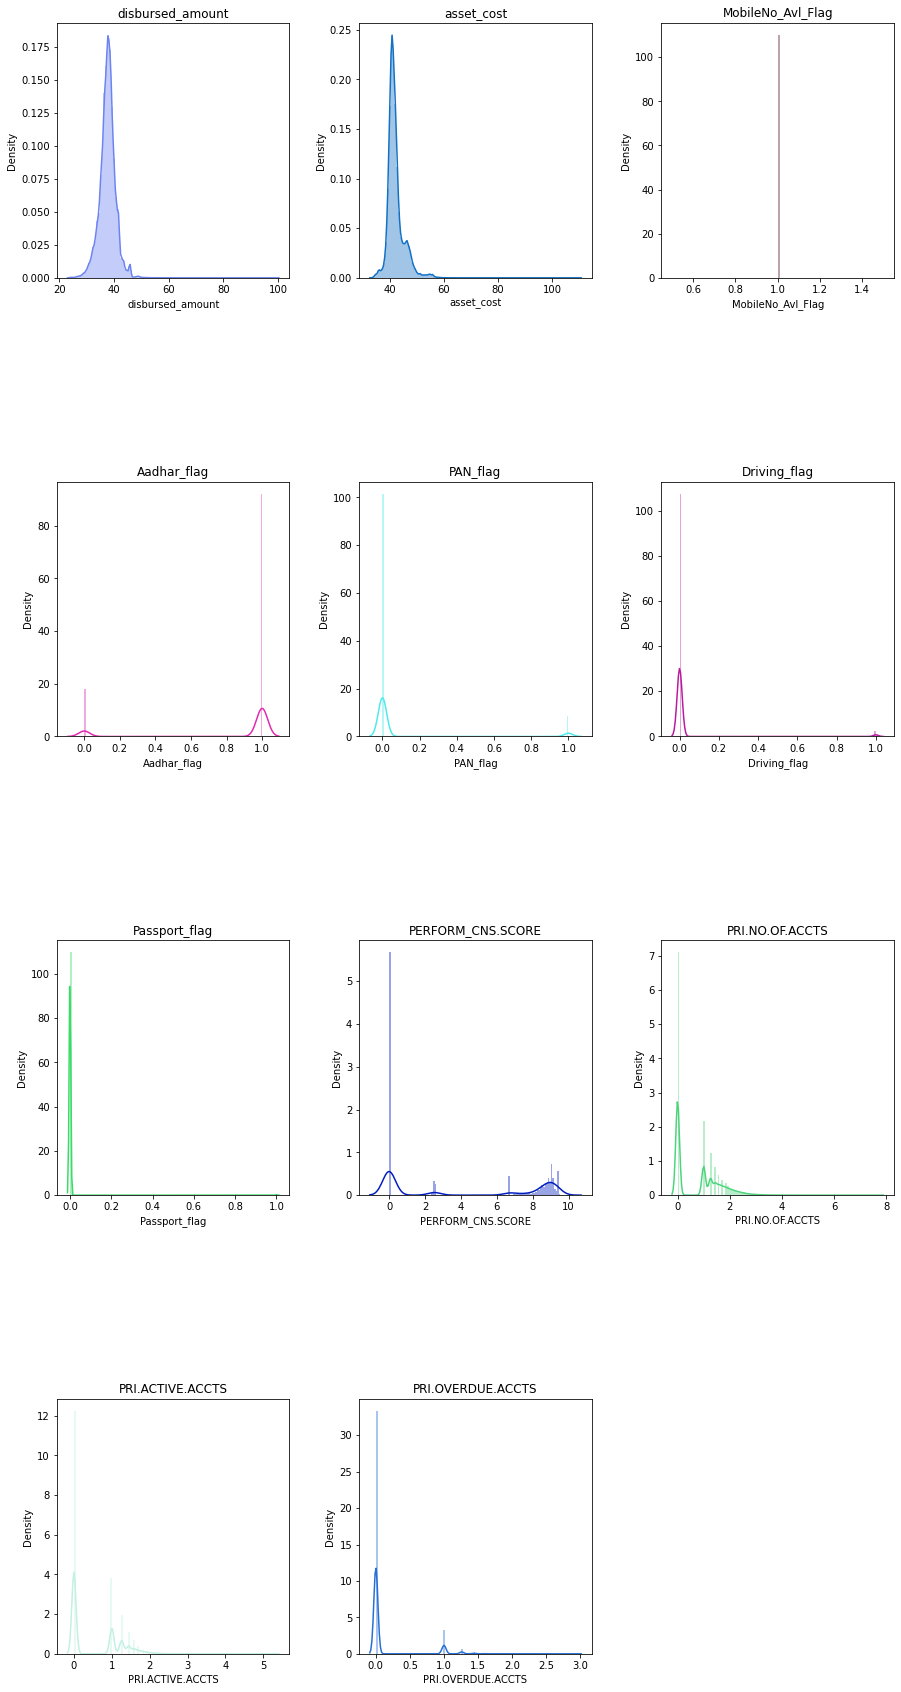

In [103]:
# распределение факторов


import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

cols_all = df.select_dtypes('int64').iloc[:, 0:18].columns.to_list()
cols_inds = [col for ind, col in enumerate(cols) if re.search('id', col.lower())]

cols = [x for x in cols if x not in cols_inds]

ncols = 3
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

for ind, col in enumerate(cols):
    ax = plt.subplot(nrows, ncols, ind + 1)

    sns.distplot(np.cbrt(df[col]), bins=110, color = (np.random.random(), np.random.random(), np.random.random()))
    plt.title(col)

plt.show()

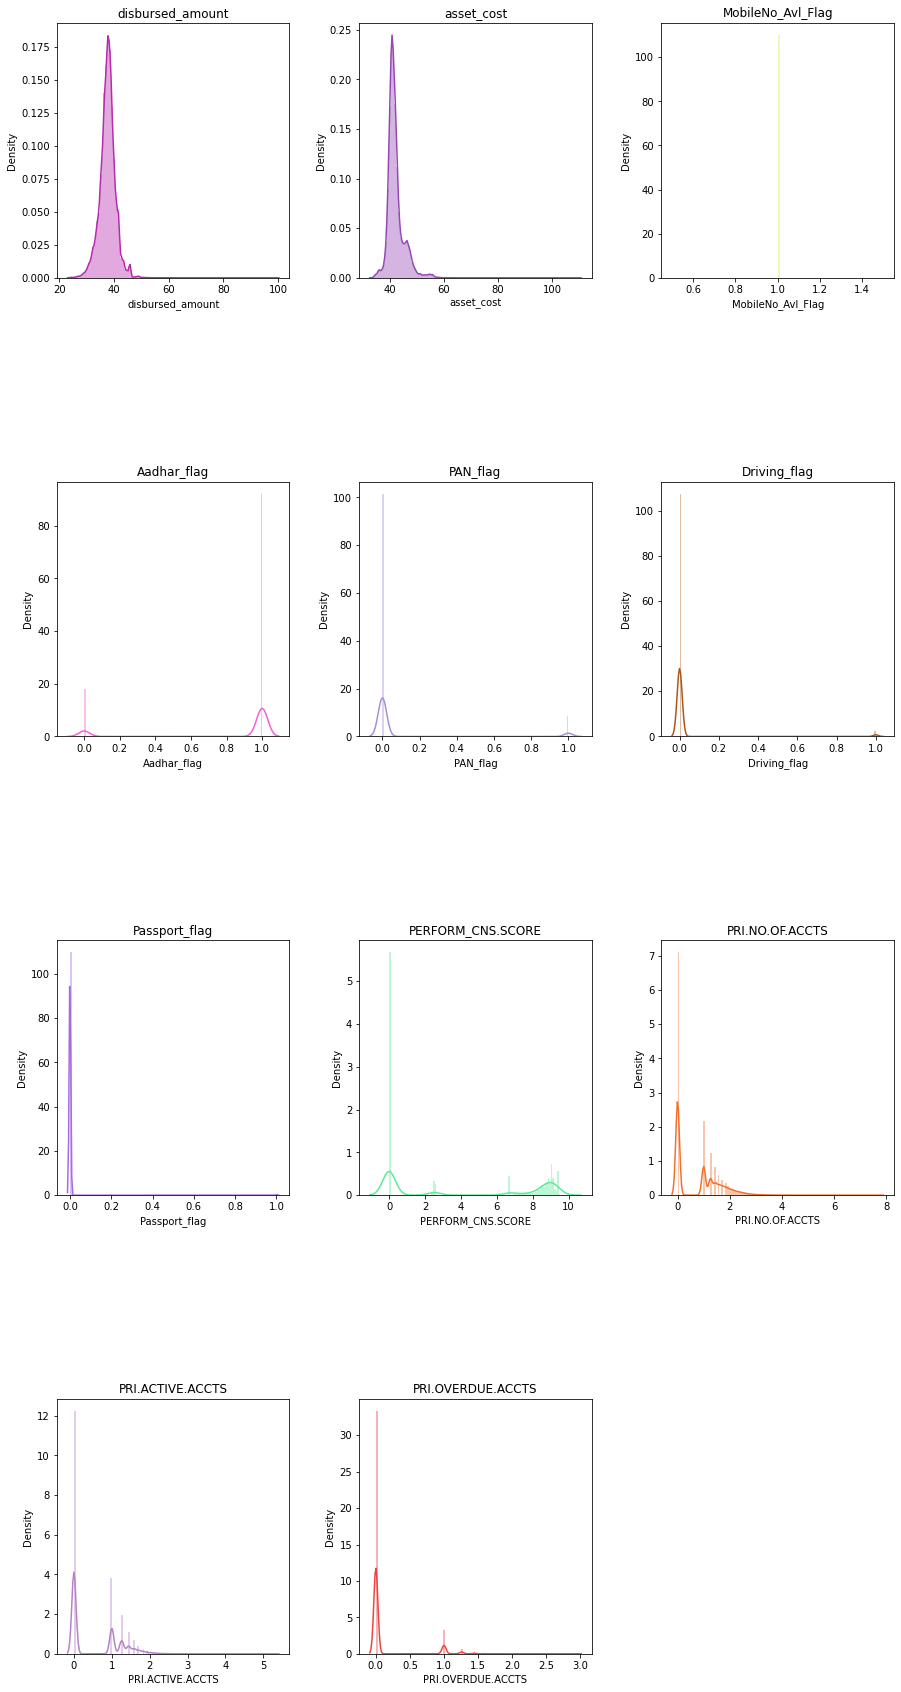

In [104]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

cols_all = df.select_dtypes('int64').iloc[:, 19:].columns.to_list()
cols_inds = [col for ind, col in enumerate(cols) if re.search('id', col.lower())]

cols = [x for x in cols if x not in cols_inds]

ncols = 3
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

for ind, col in enumerate(cols):
    ax = plt.subplot(nrows, ncols, ind + 1)

    sns.distplot(np.cbrt(df[col]), bins=110, color = (np.random.random(), np.random.random(), np.random.random()))
    plt.title(col)

plt.show()

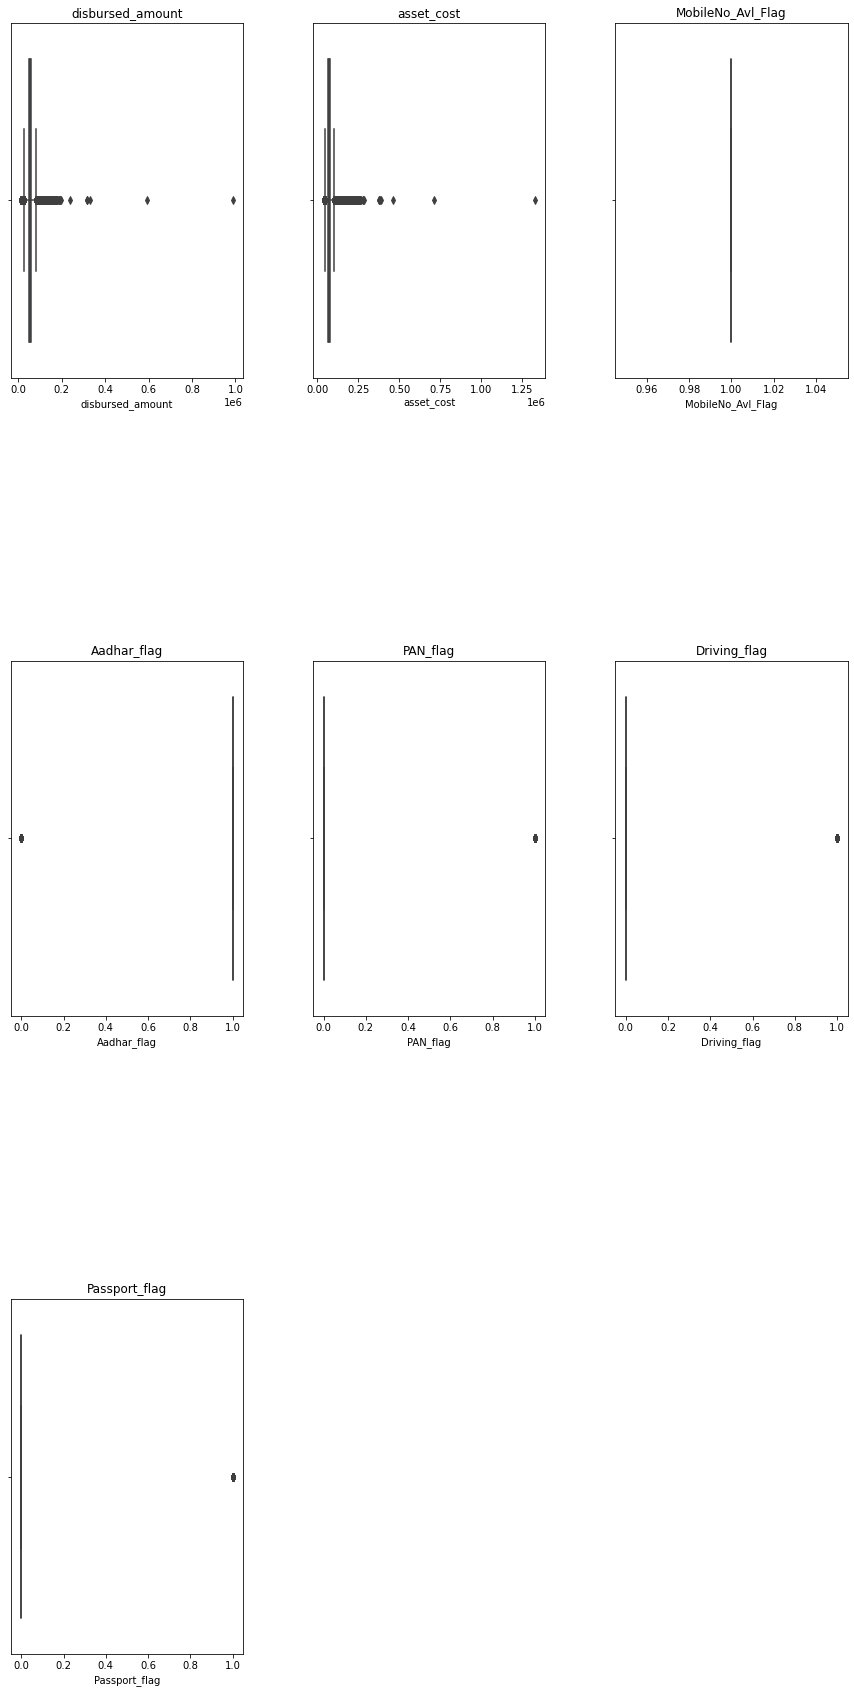

In [20]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

cols_all = df.iloc[:, 0:18].select_dtypes('int64').columns.to_list()
cols_inds = [col for ind, col in enumerate(cols_all) if re.search('id', col.lower())]

cols = [x for x in cols_all if x not in cols_inds]

ncols = 3
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

for ind, col in enumerate(cols):
    ax = plt.subplot(nrows, ncols, ind + 1)

    sns.boxplot(x=df[col])
    plt.title(col)

plt.show()

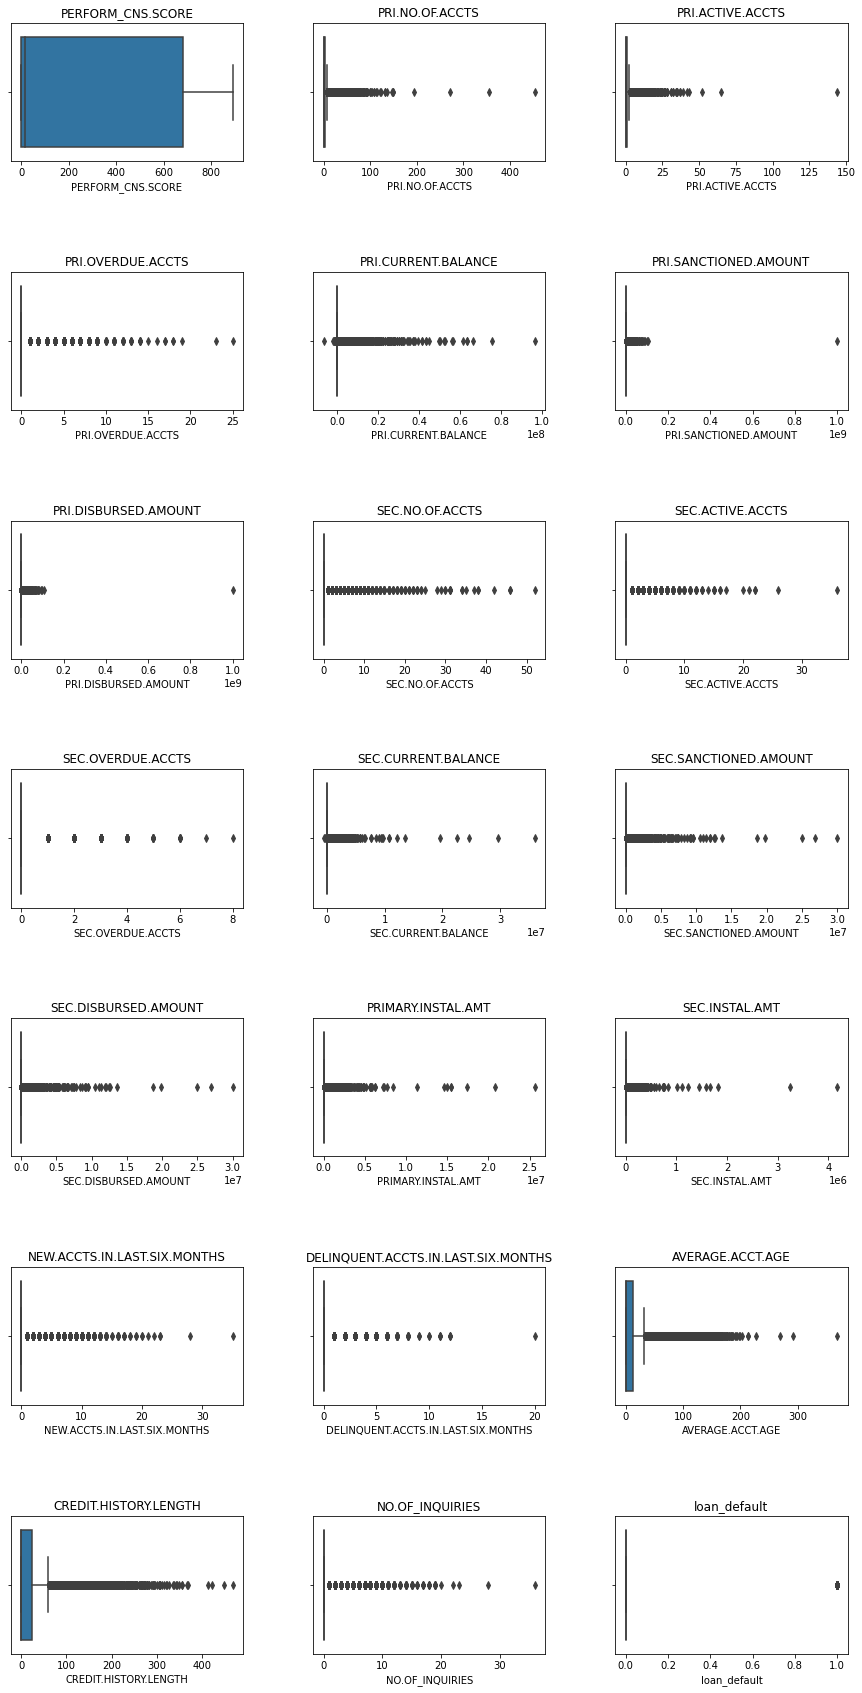

In [21]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

cols_all = df.iloc[:, 18:].select_dtypes('int64').columns.to_list()
cols_inds = [col for ind, col in enumerate(cols_all) if re.search('id', col.lower())]

cols = [x for x in cols_all if x not in cols_inds]

ncols = 3
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

for ind, col in enumerate(cols):
    ax = plt.subplot(nrows, ncols, ind + 1)

    sns.boxplot(x=df[col])
    plt.title(col)

plt.show()

В датасете много выбросов - при построении моделей будем нормировать данные и выбирать признаки